In [1]:

!pip install gdown
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 50kB/s 


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output spx.csv

Downloading...
From: https://drive.google.com/uc?id=10vdMg_RazoIatwrT7azKFX4P02OebU76
To: /content/spx.csv
100% 152k/152k [00:00<00:00, 70.0MB/s]


In [4]:
df = pd.read_csv('/content/spx.csv', parse_dates=['date'], index_col='date')

In [5]:
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


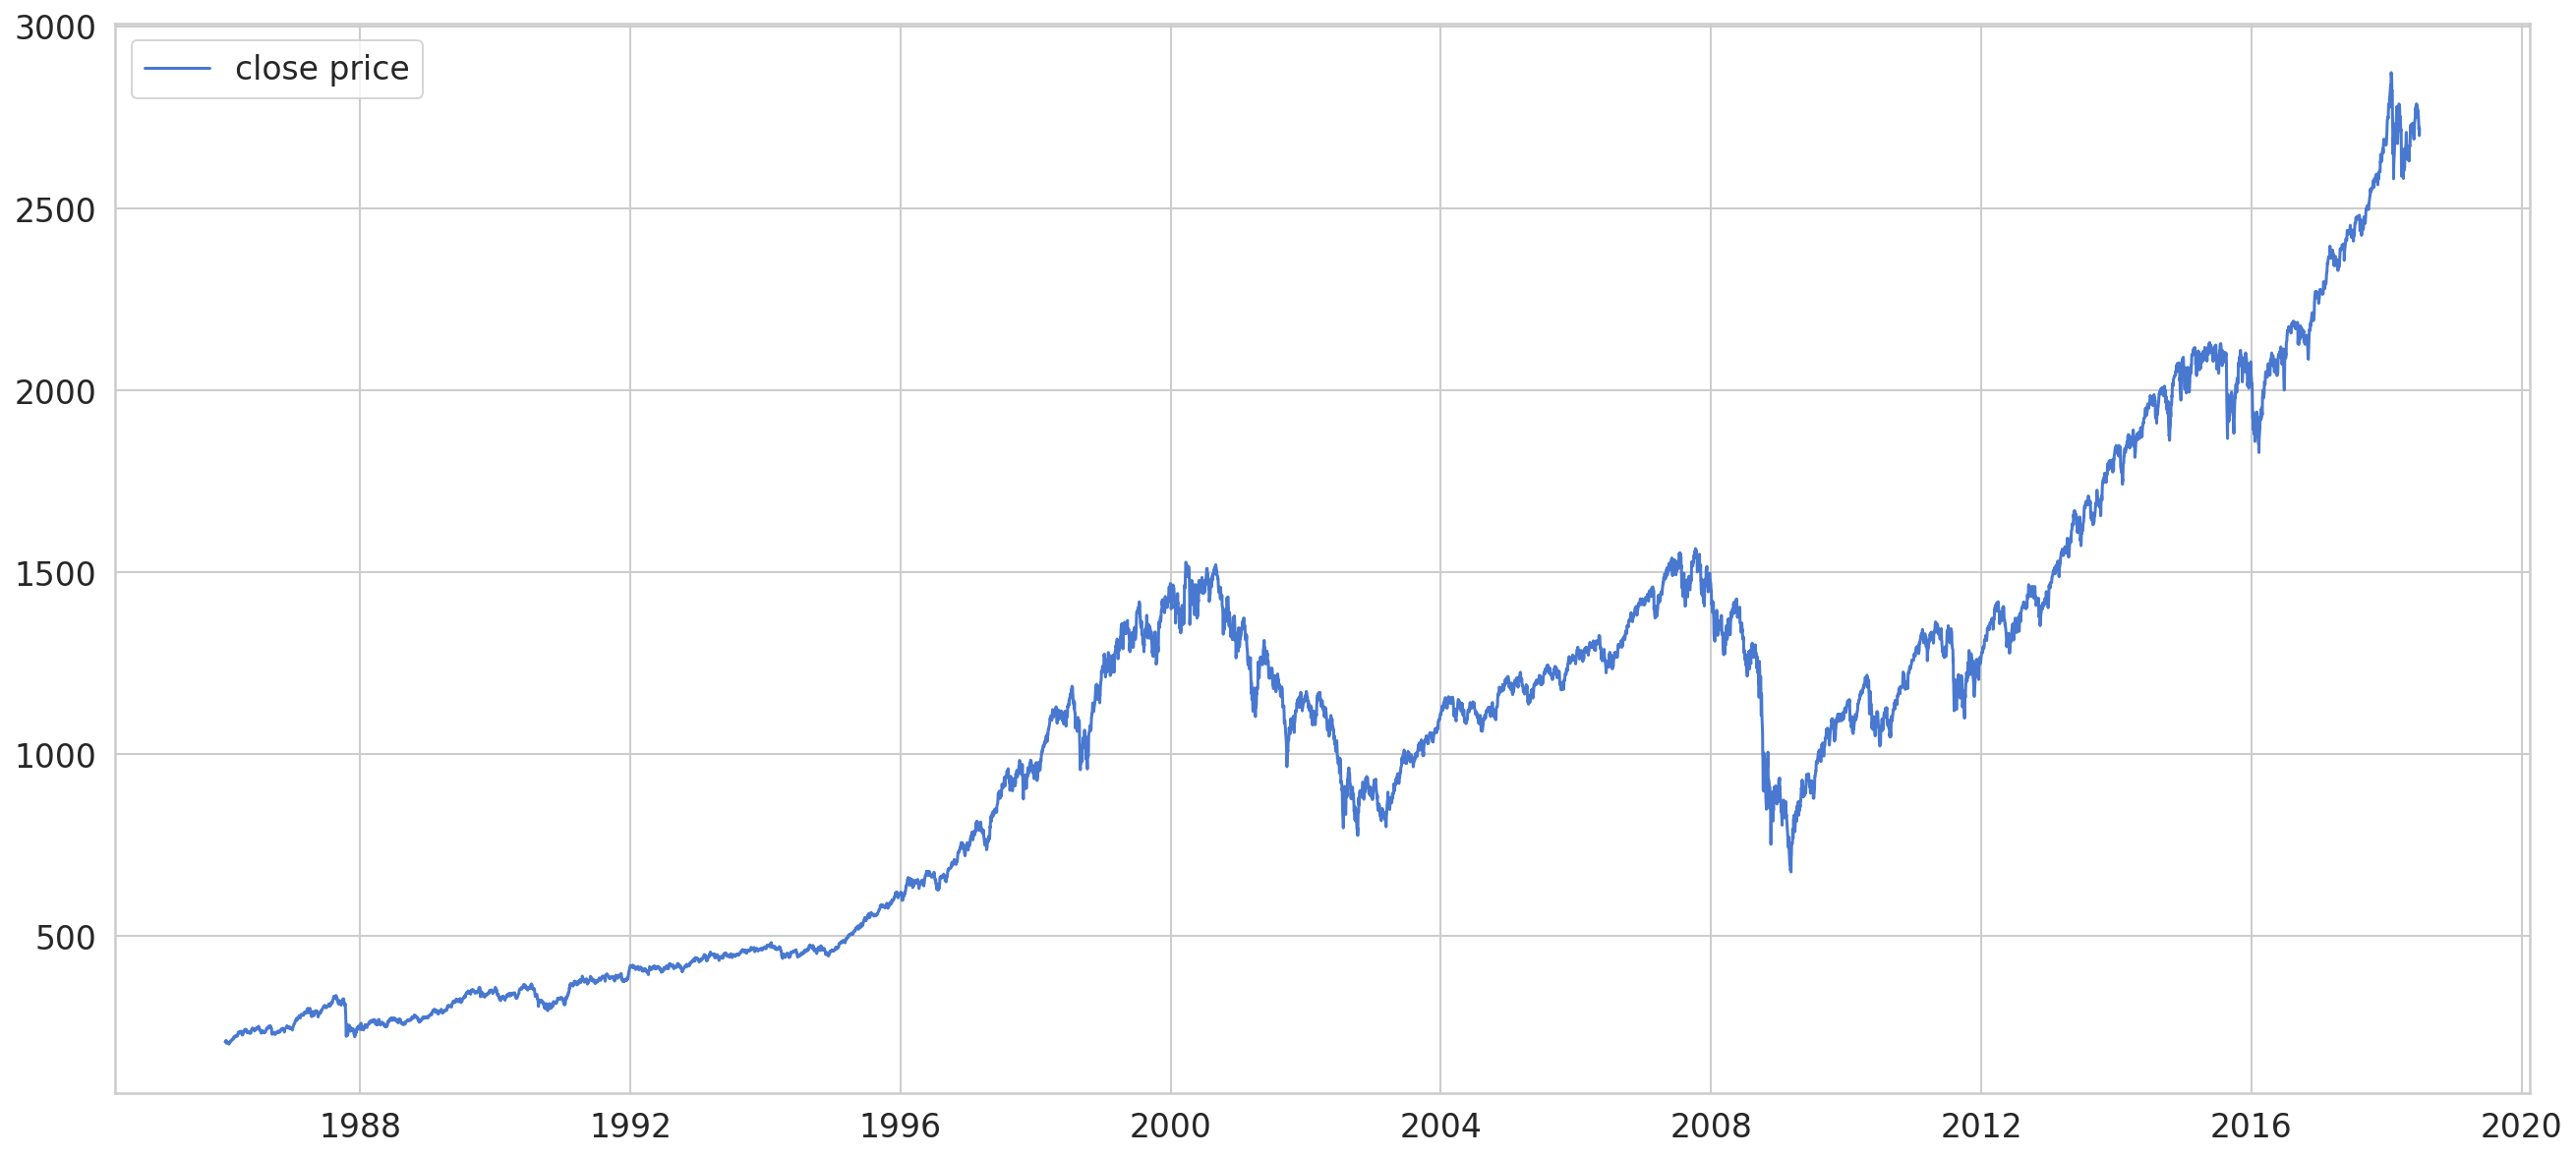

In [6]:
plt.plot(df, label= 'close price')
plt.legend()

In [81]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [82]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [83]:
train.head()

,close
date,
1986-01-02,-1.475126
1986-01-03,-1.472703
1986-01-06,-1.473135
1986-01-07,-1.467219
1986-01-08,-1.478169


In [84]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [85]:
TIME_STEPS = 30

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(7752, 30, 1)


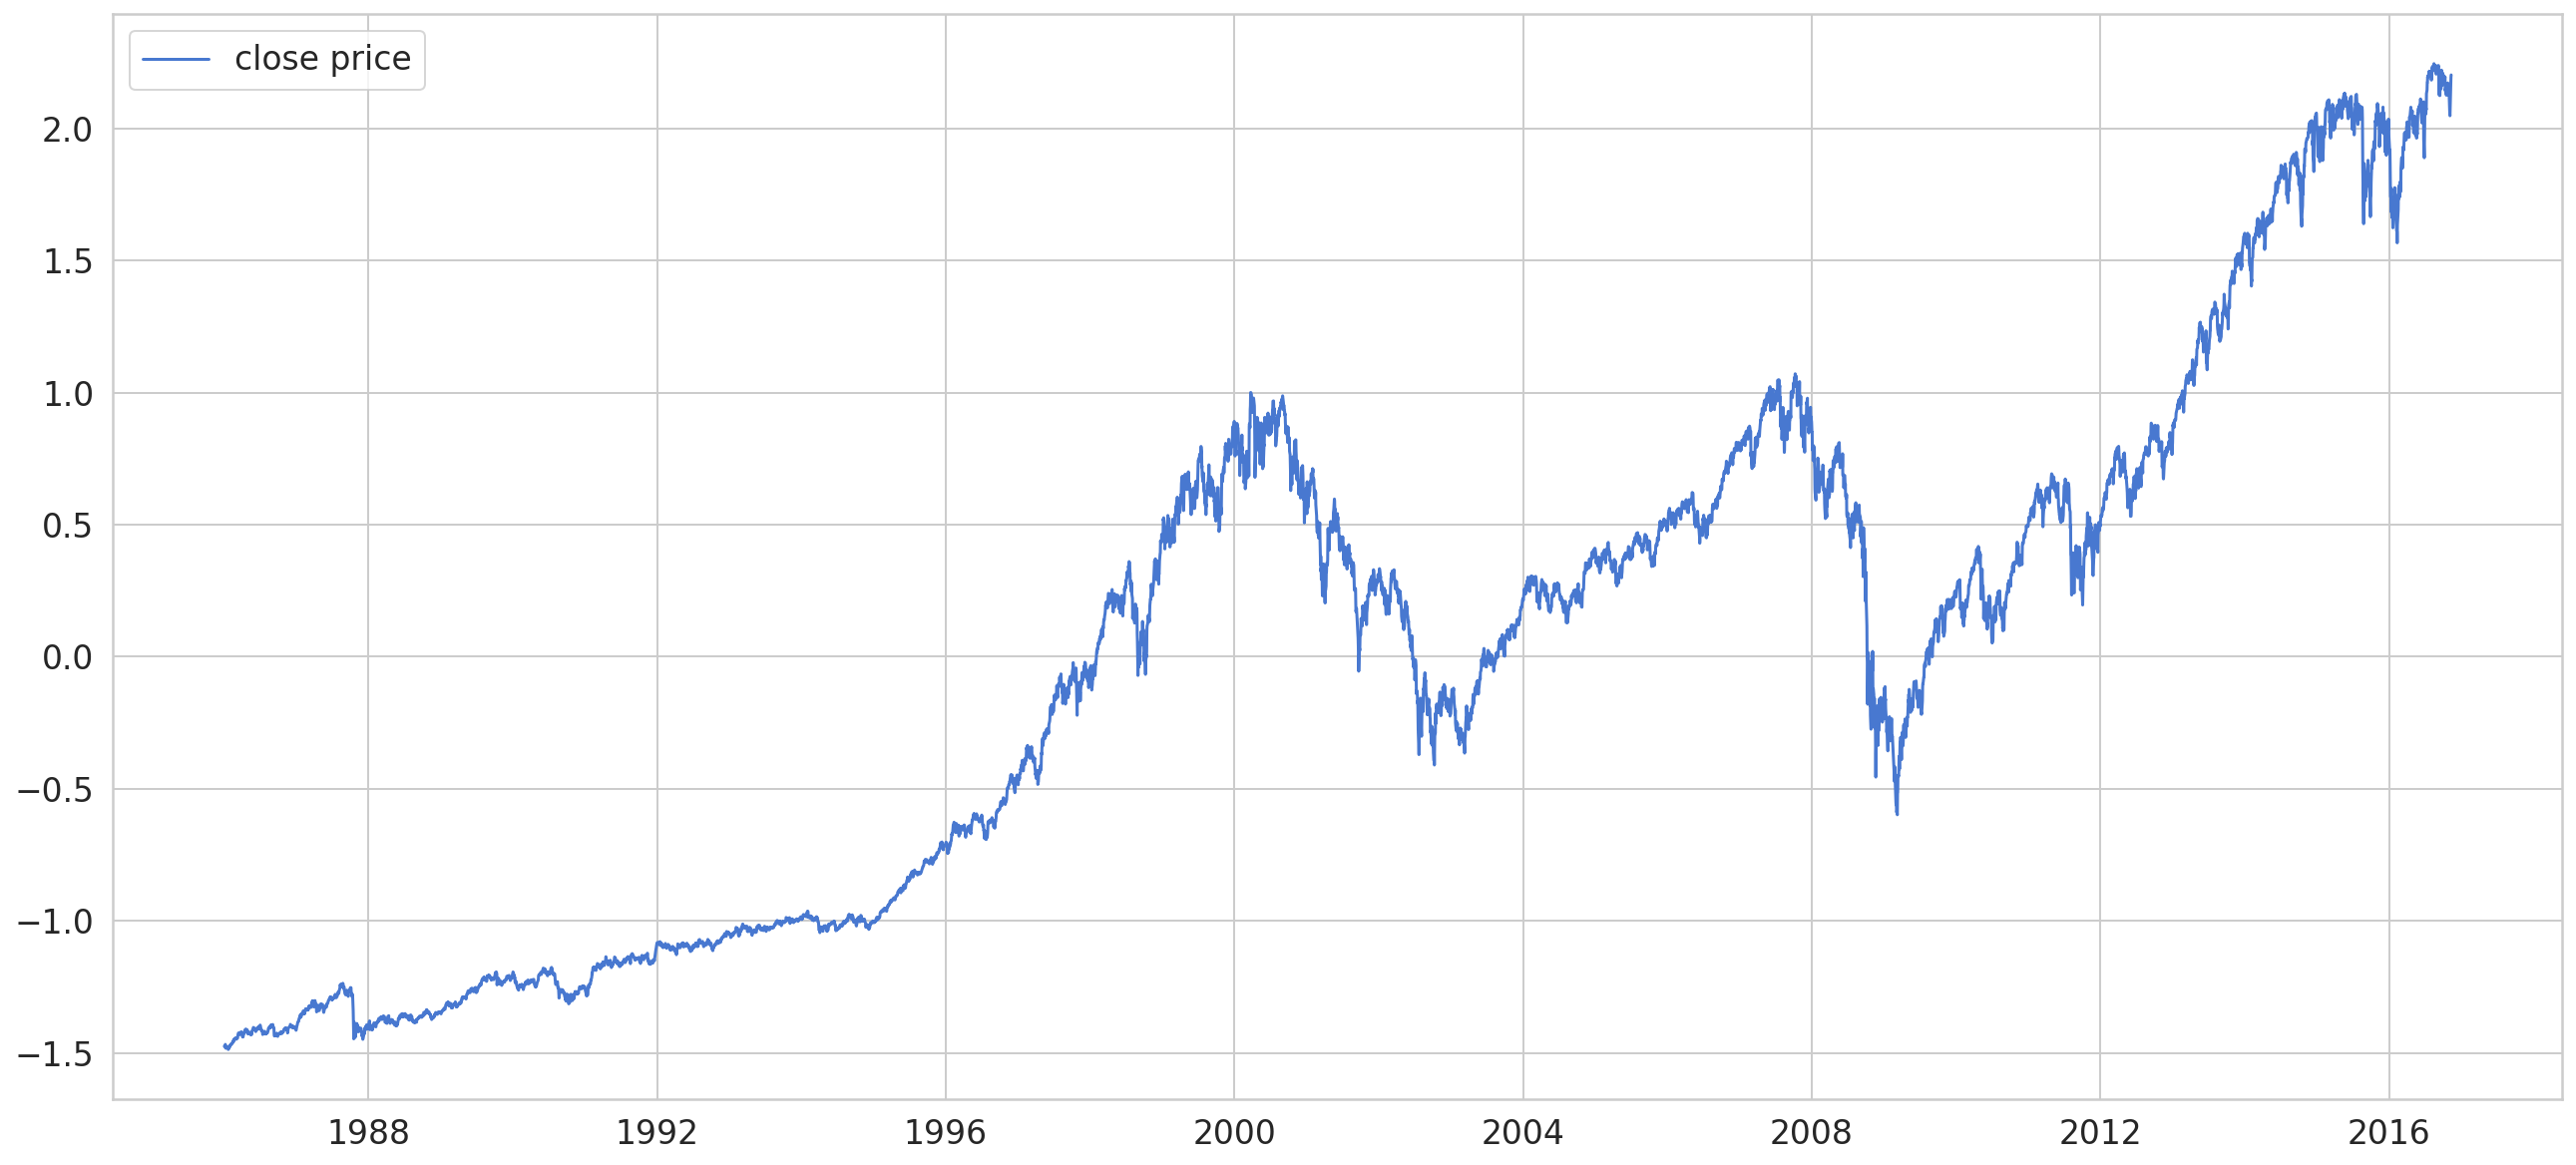

In [86]:
plt.plot(train, label= 'close price')
plt.legend()

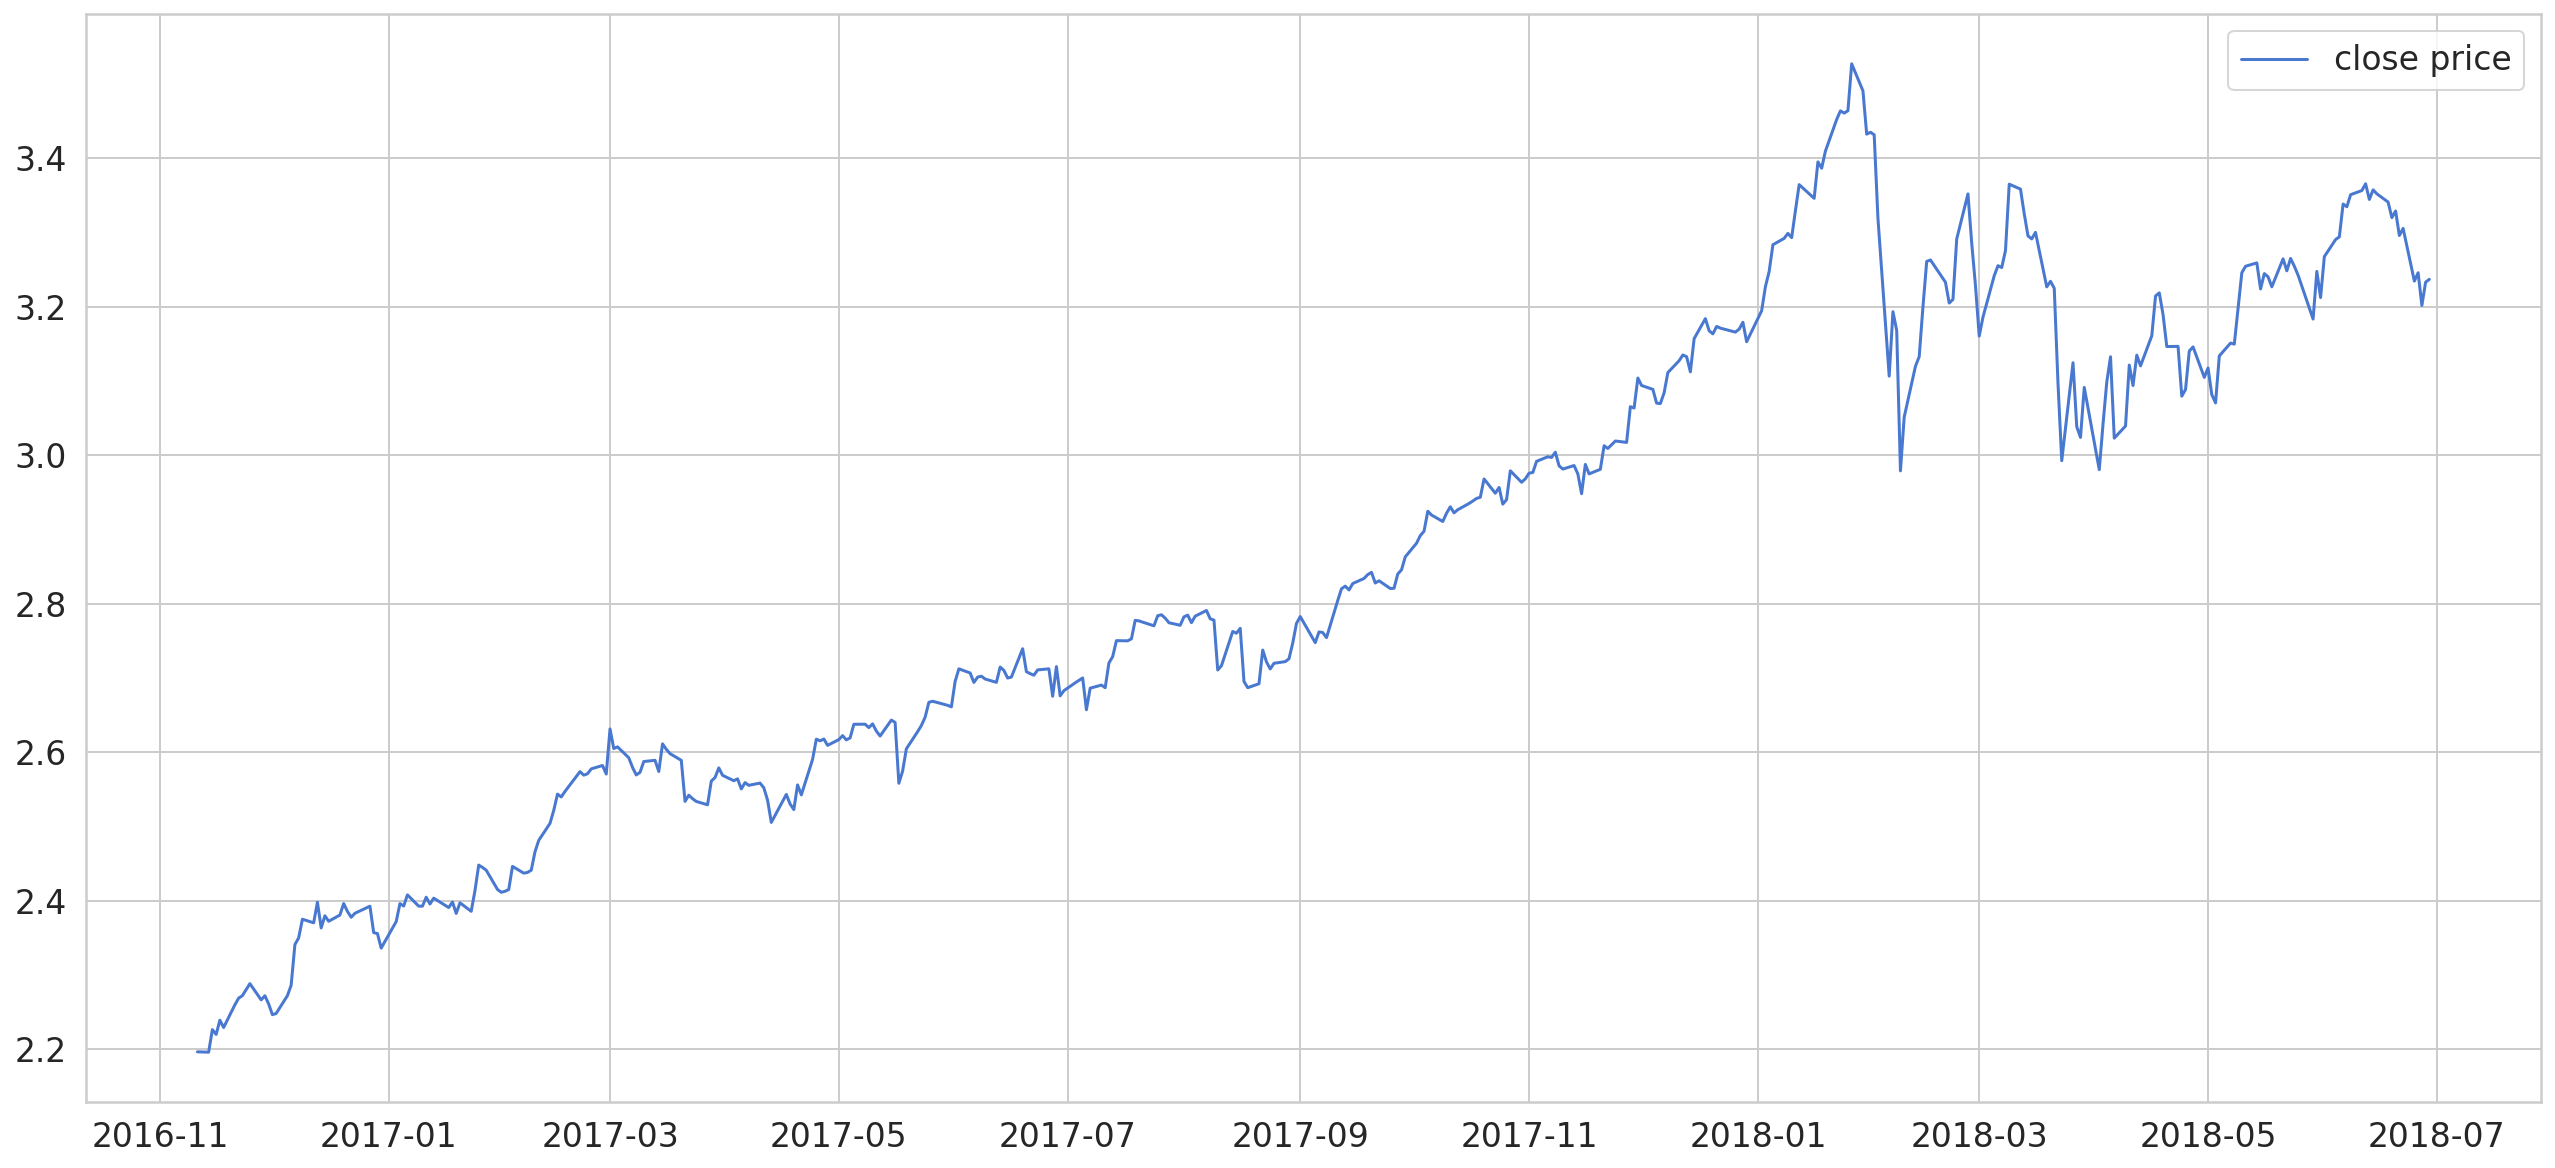

In [87]:
plt.plot(test, label='close price')
plt.legend()

In [88]:
y_train.shape

(7752,)

In [92]:
input = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = keras.layers.LSTM(64)(input)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.RepeatVector(n=X_train.shape[1])(x)
x = keras.layers.LSTM(64, return_sequences=True)(x)
x = keras.layers.Dropout( rate=0.2)(x)
x = keras.layers.TimeDistributed(keras.layers.Dense(X_train.shape[2]))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1)(x)
model = keras.Model(inputs=input, outputs=x)
model.summary()
model.compile(loss='mae', optimizer='adam')

Model: "functional_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 30, 1)]           0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
repeat_vector_15 (RepeatVect (None, 30, 64)            0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 30, 64)            33024     
_________________________________________________________________
dropout_29 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 30, 1)           

In [93]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/10
218/218 [==============================] - 4s 20ms/step - loss: 0.1857 - val_loss: 0.3104
Epoch 2/10
218/218 [==============================] - 4s 17ms/step - loss: 0.0949 - val_loss: 0.1351
Epoch 3/10
218/218 [==============================] - 4s 17ms/step - loss: 0.0762 - val_loss: 0.0691
Epoch 4/10
218/218 [==============================] - 4s 17ms/step - loss: 0.0804 - val_loss: 0.1239
Epoch 5/10
218/218 [==============================] - 4s 16ms/step - loss: 0.0837 - val_loss: 0.0799
Epoch 6/10
218/218 [==============================] - 4s 16ms/step - loss: 0.0873 - val_loss: 0.0973
Epoch 7/10
218/218 [==============================] - 4s 16ms/step - loss: 0.0859 - val_loss: 0.0883
Epoch 8/10
218/218 [==============================] - 4s 17ms/step - loss: 0.0952 - val_loss: 0.0860


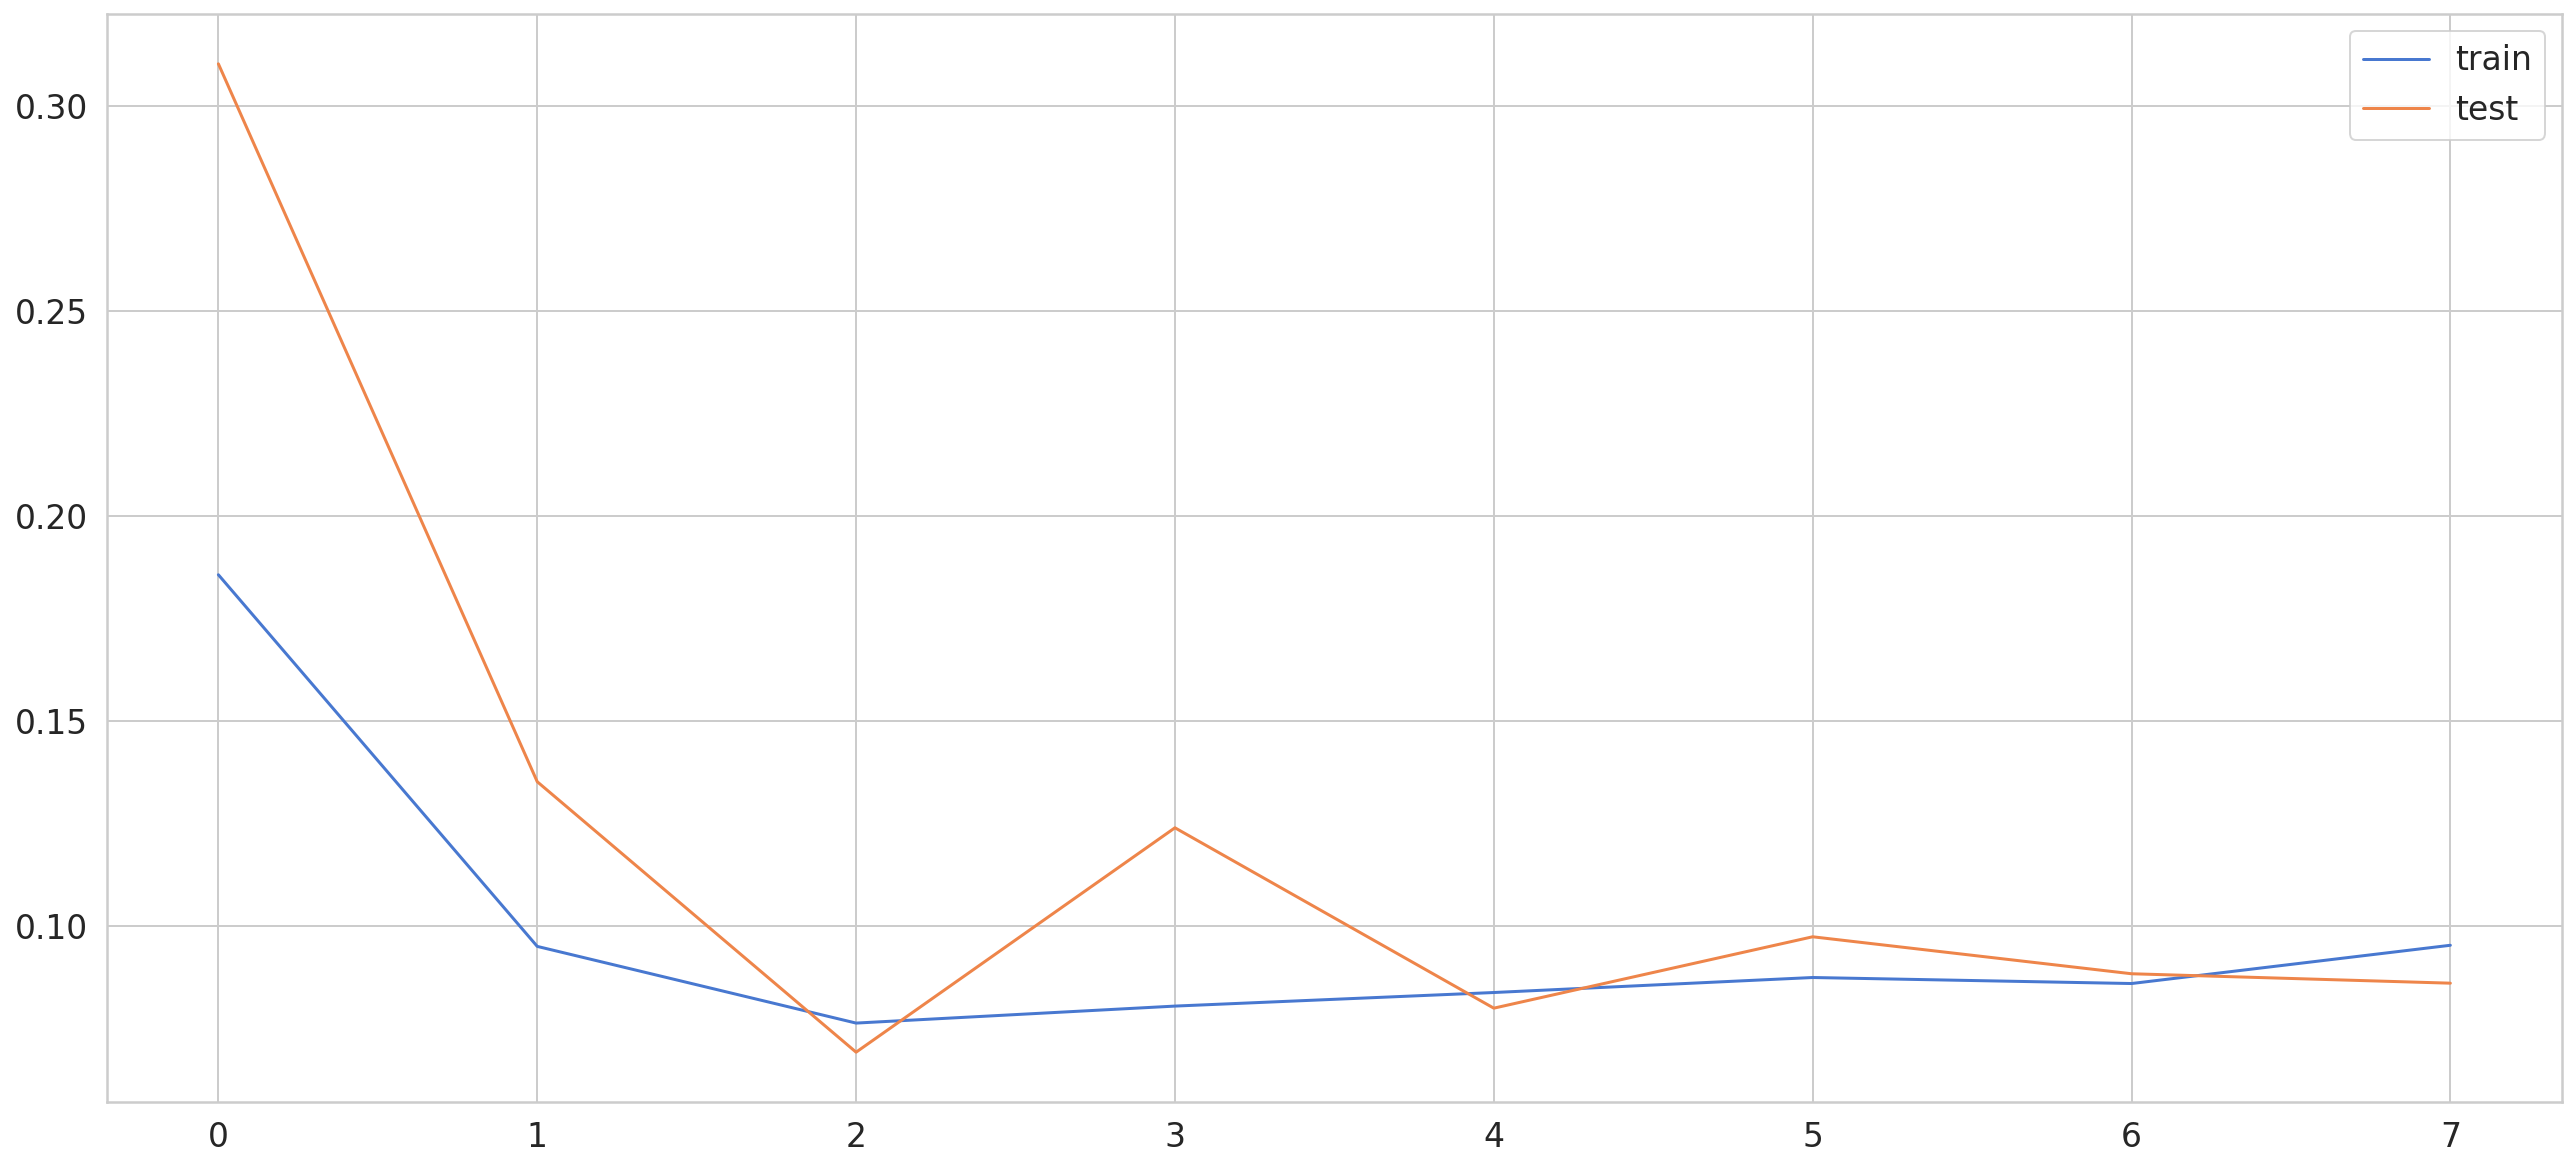

In [94]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [95]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - y_train), axis=1)

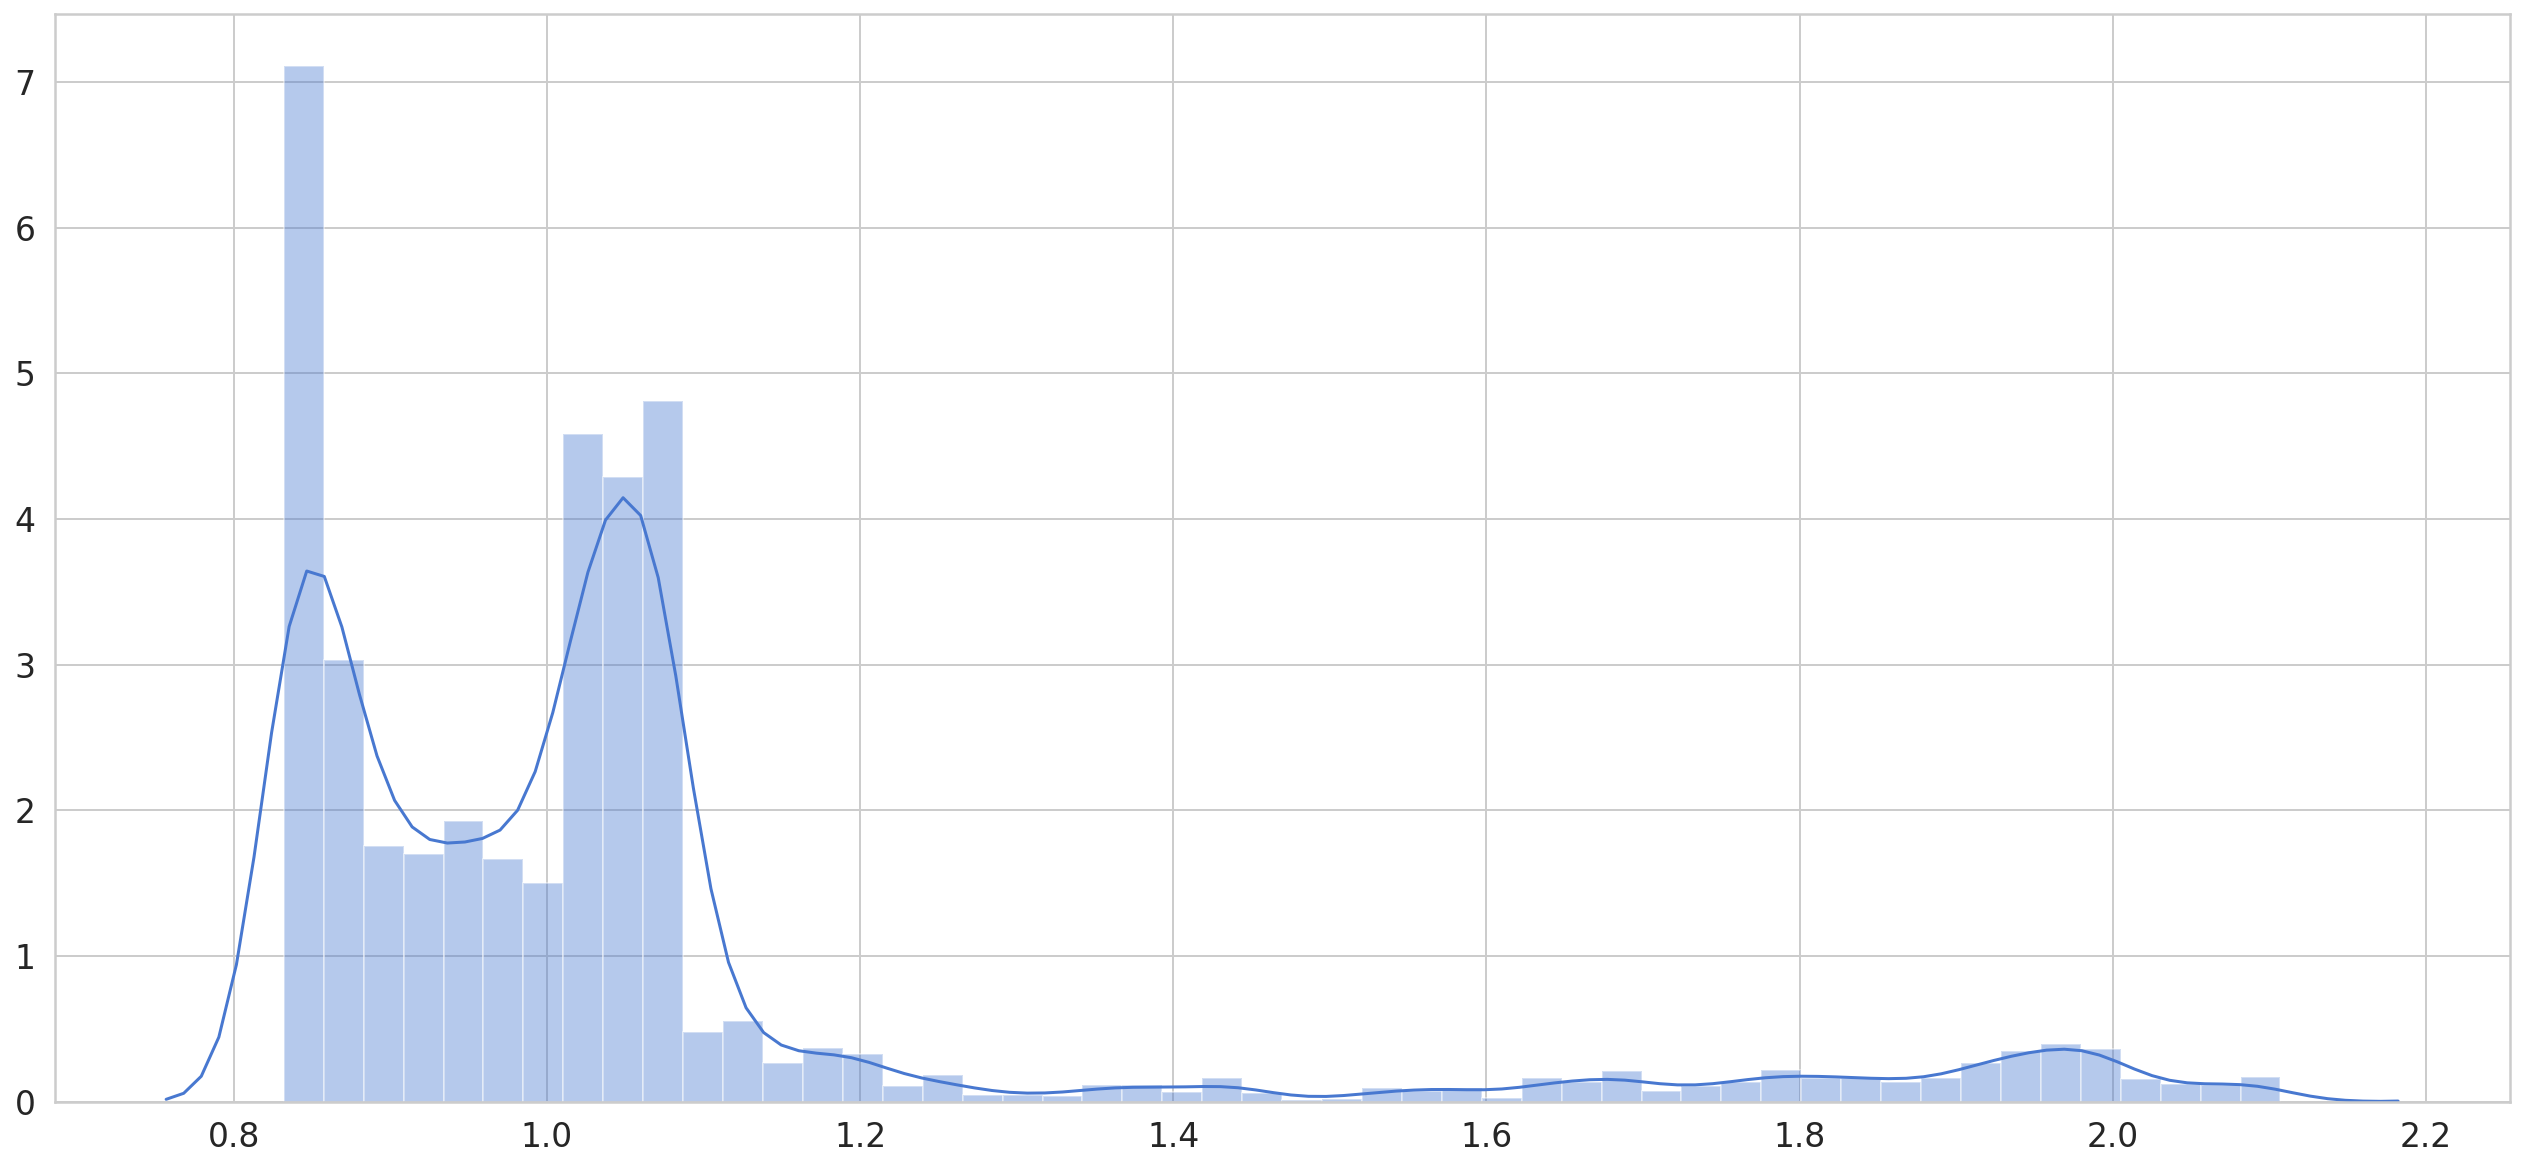

In [96]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [97]:

X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - y_test), axis=1)

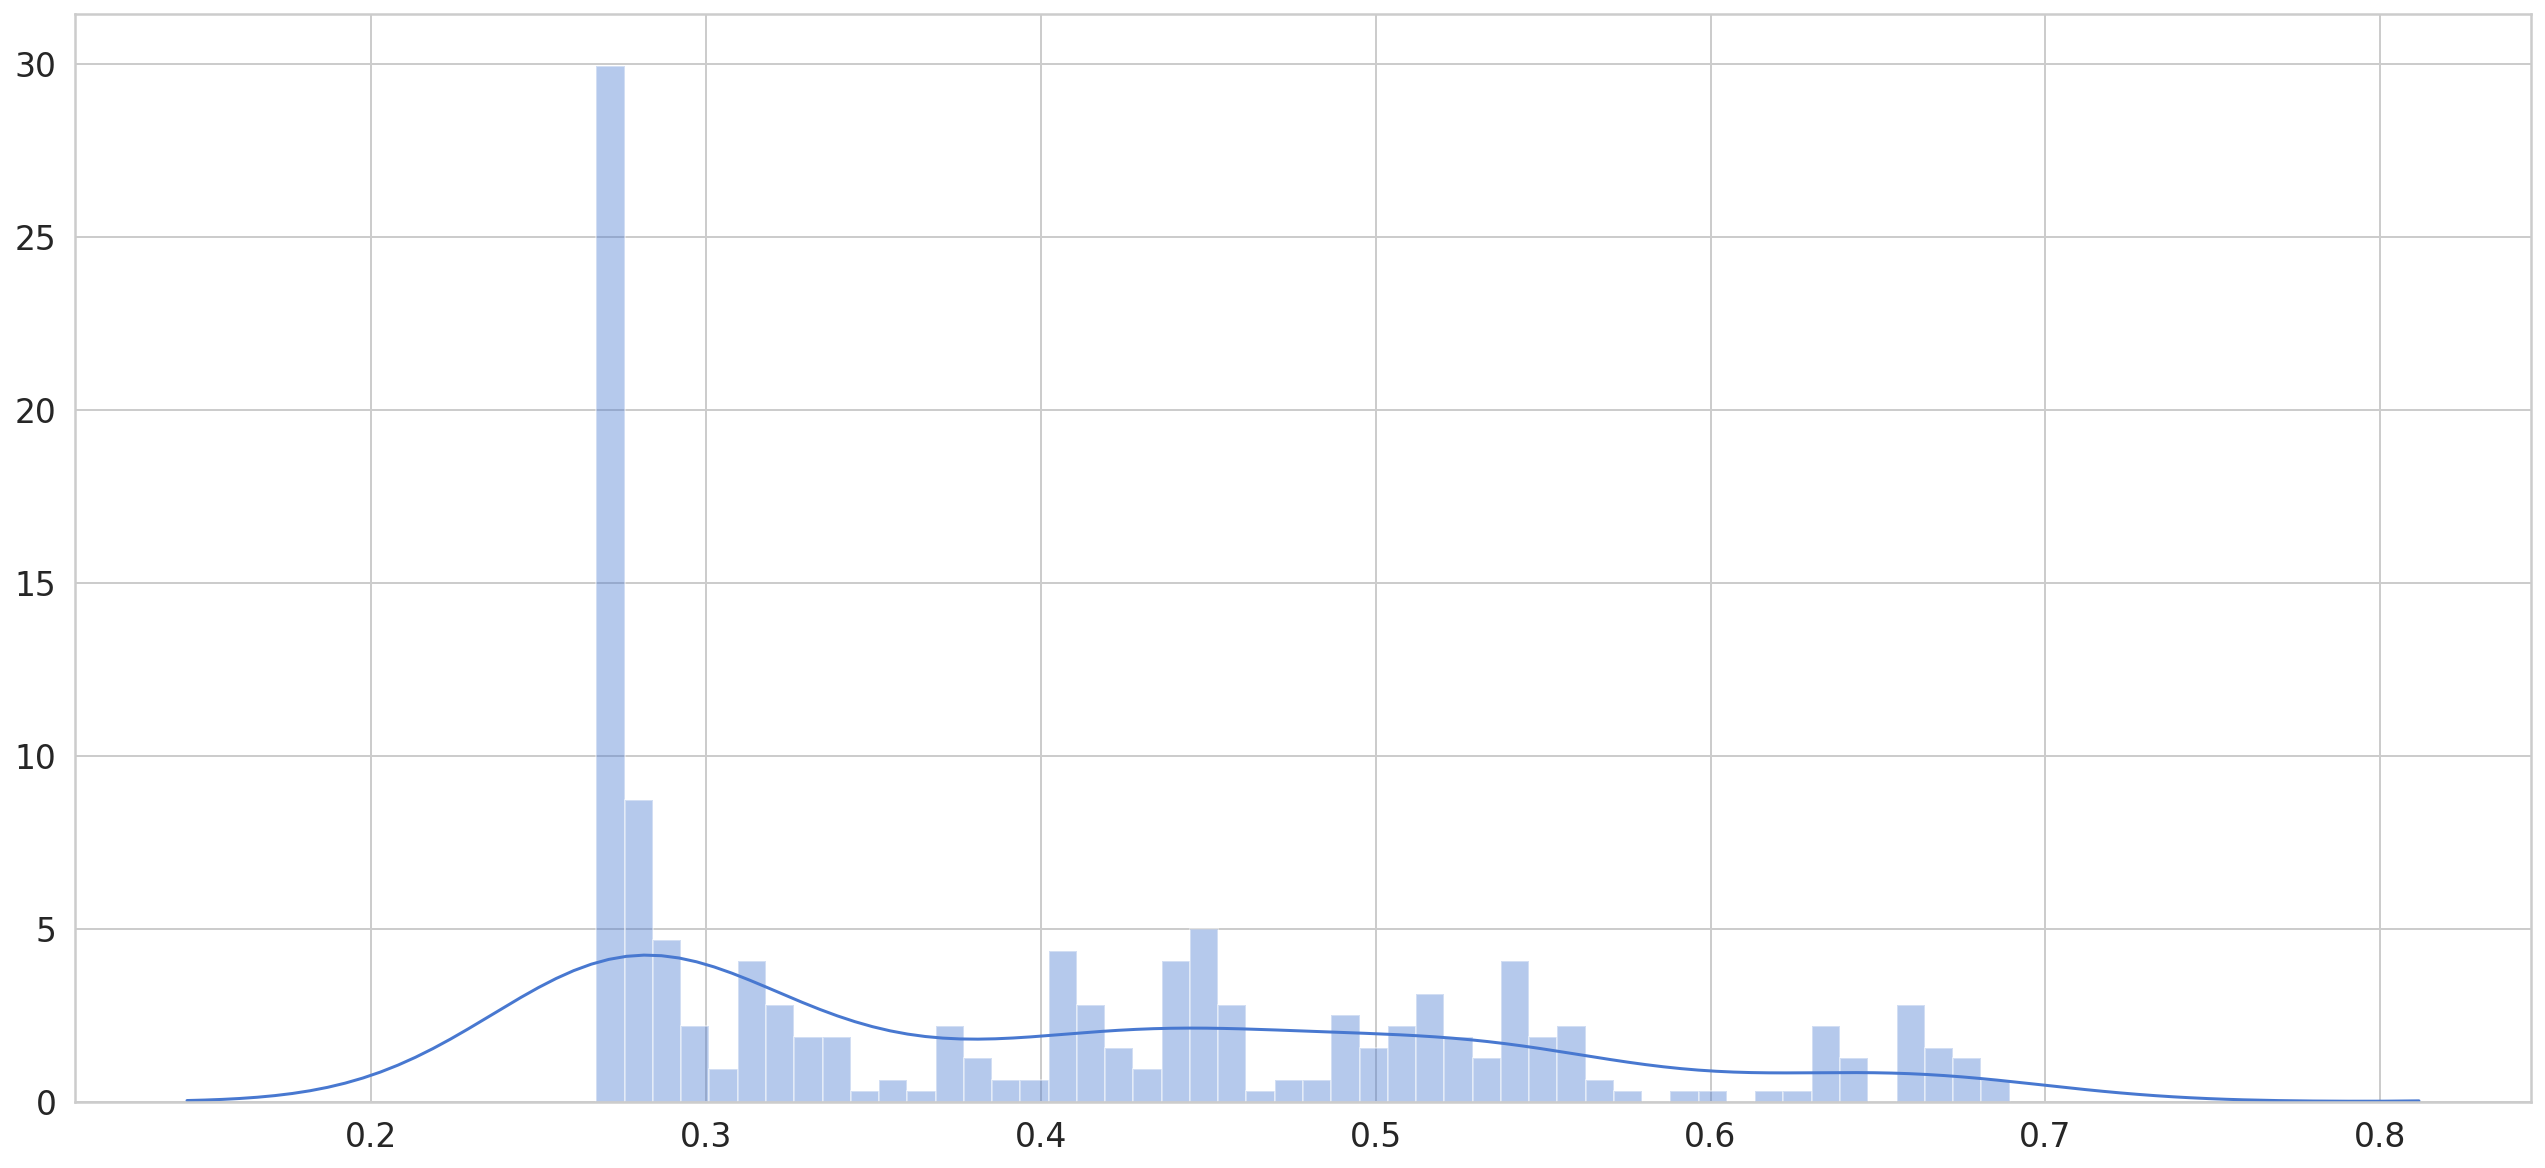

In [98]:
sns.distplot(test_mae_loss, bins=50, kde=True);

In [99]:
# THRESHOLD = 1.2
THRESHOLD = np.percentile(test_mae_loss, 96)
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

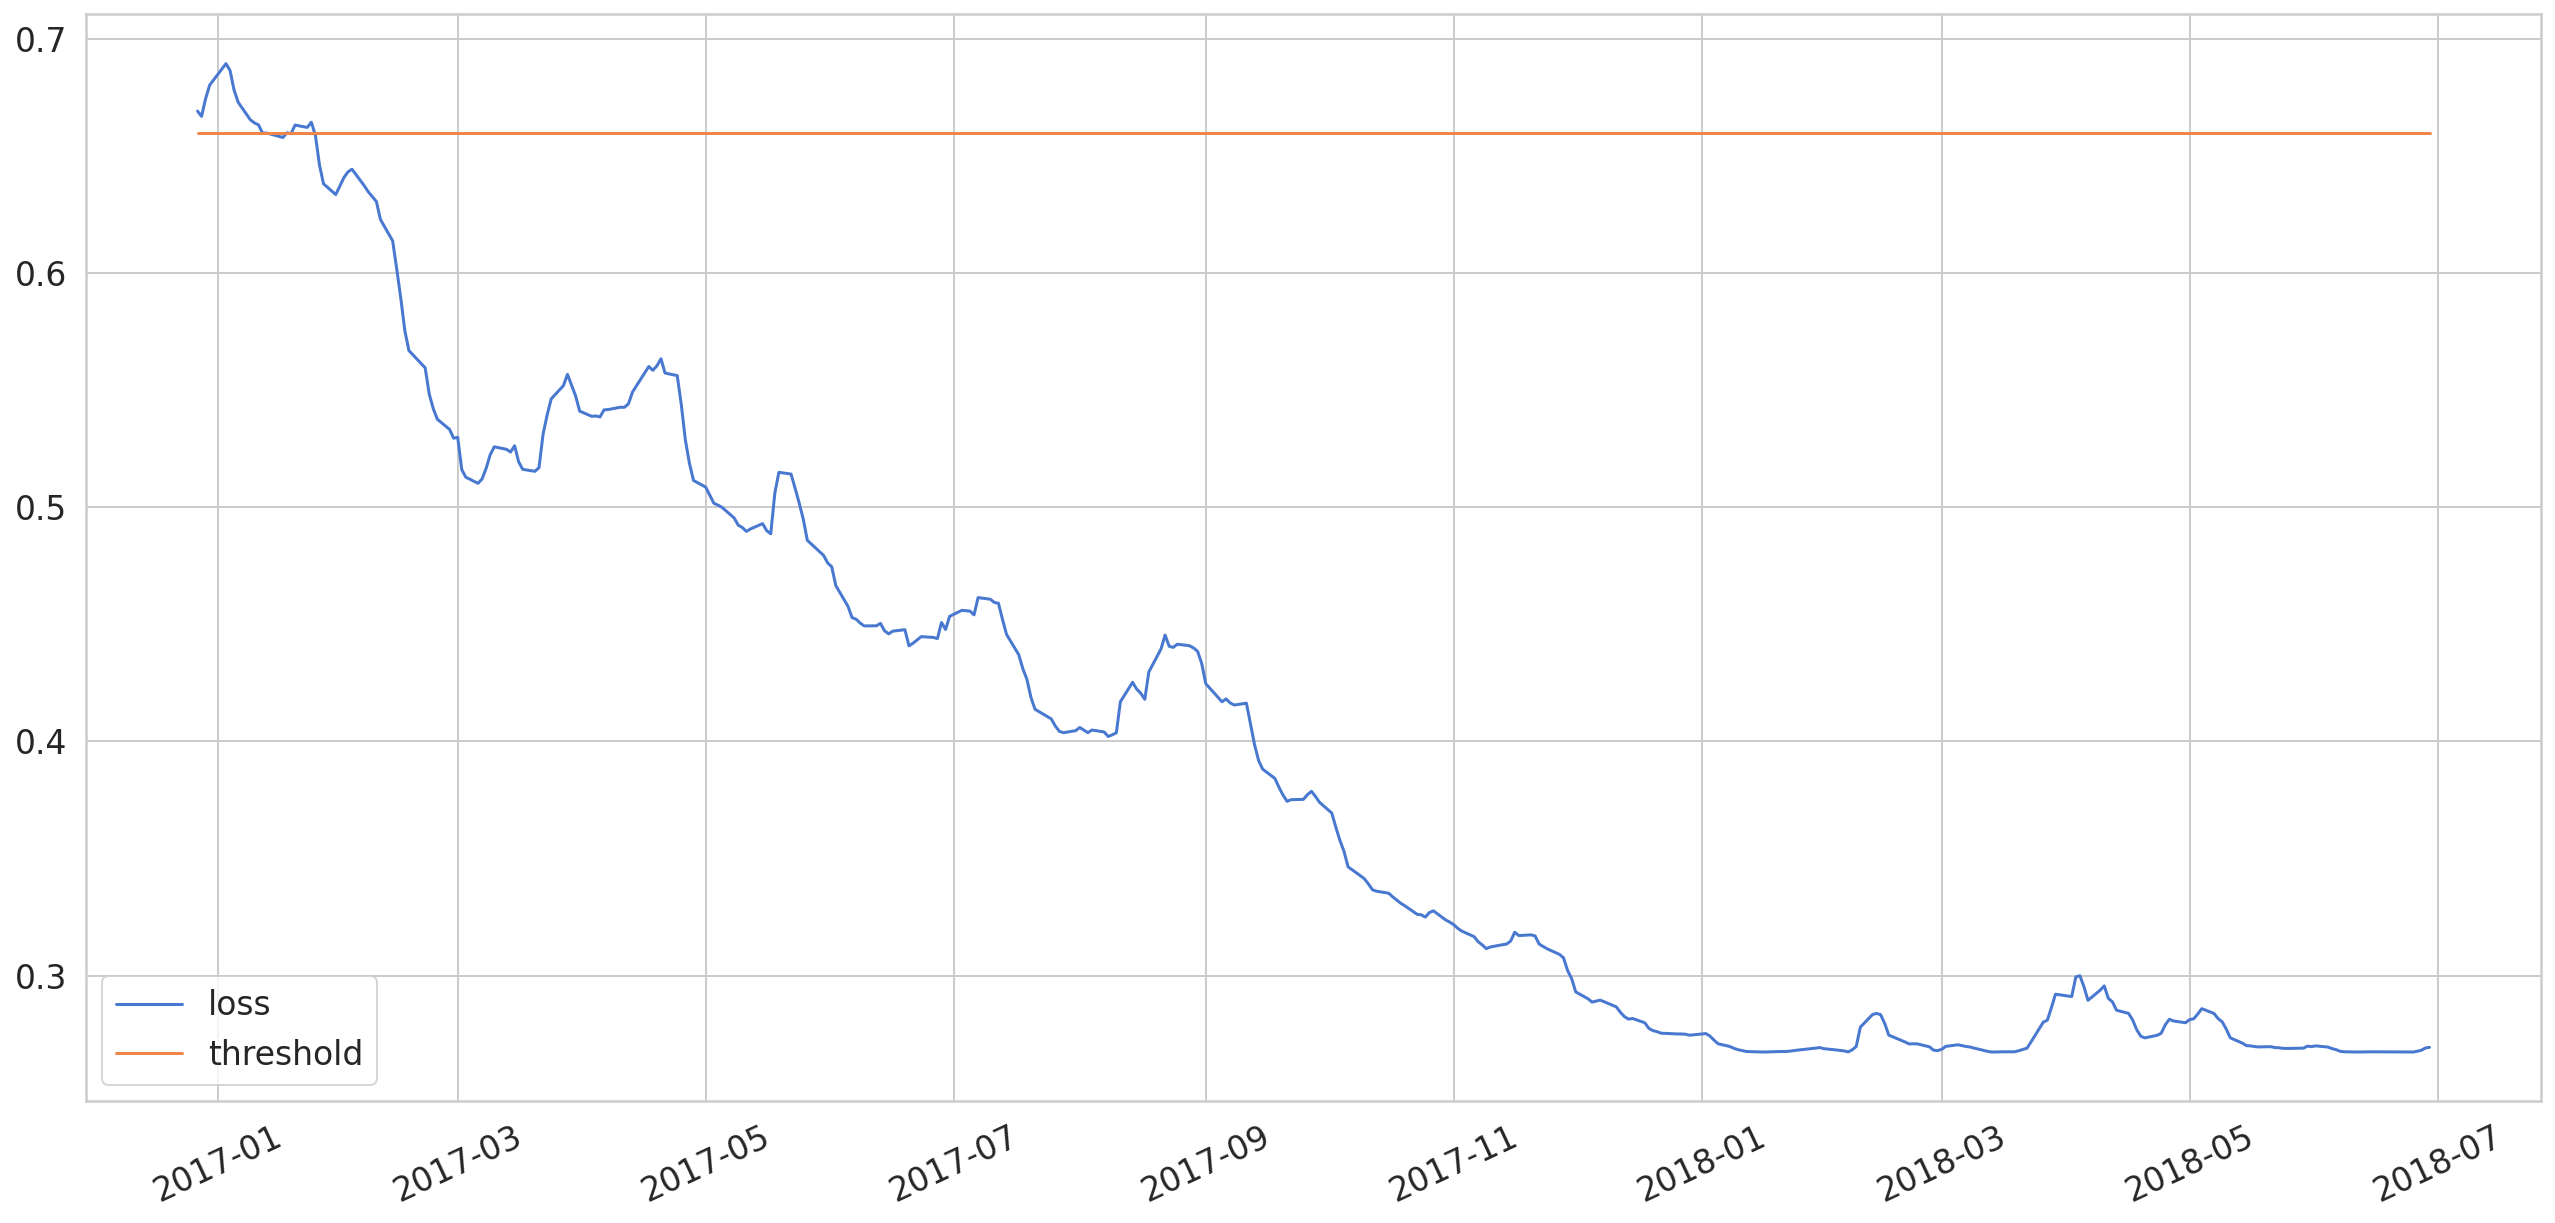

In [100]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [101]:

anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2016-12-27,0.669040,0.659669,True,2.392816
2016-12-28,0.666760,0.659669,True,2.357204
2016-12-29,0.674397,0.659669,True,2.355964
2016-12-30,0.680155,0.659669,True,2.336373
2017-01-03,0.689289,0.659669,True,2.372061


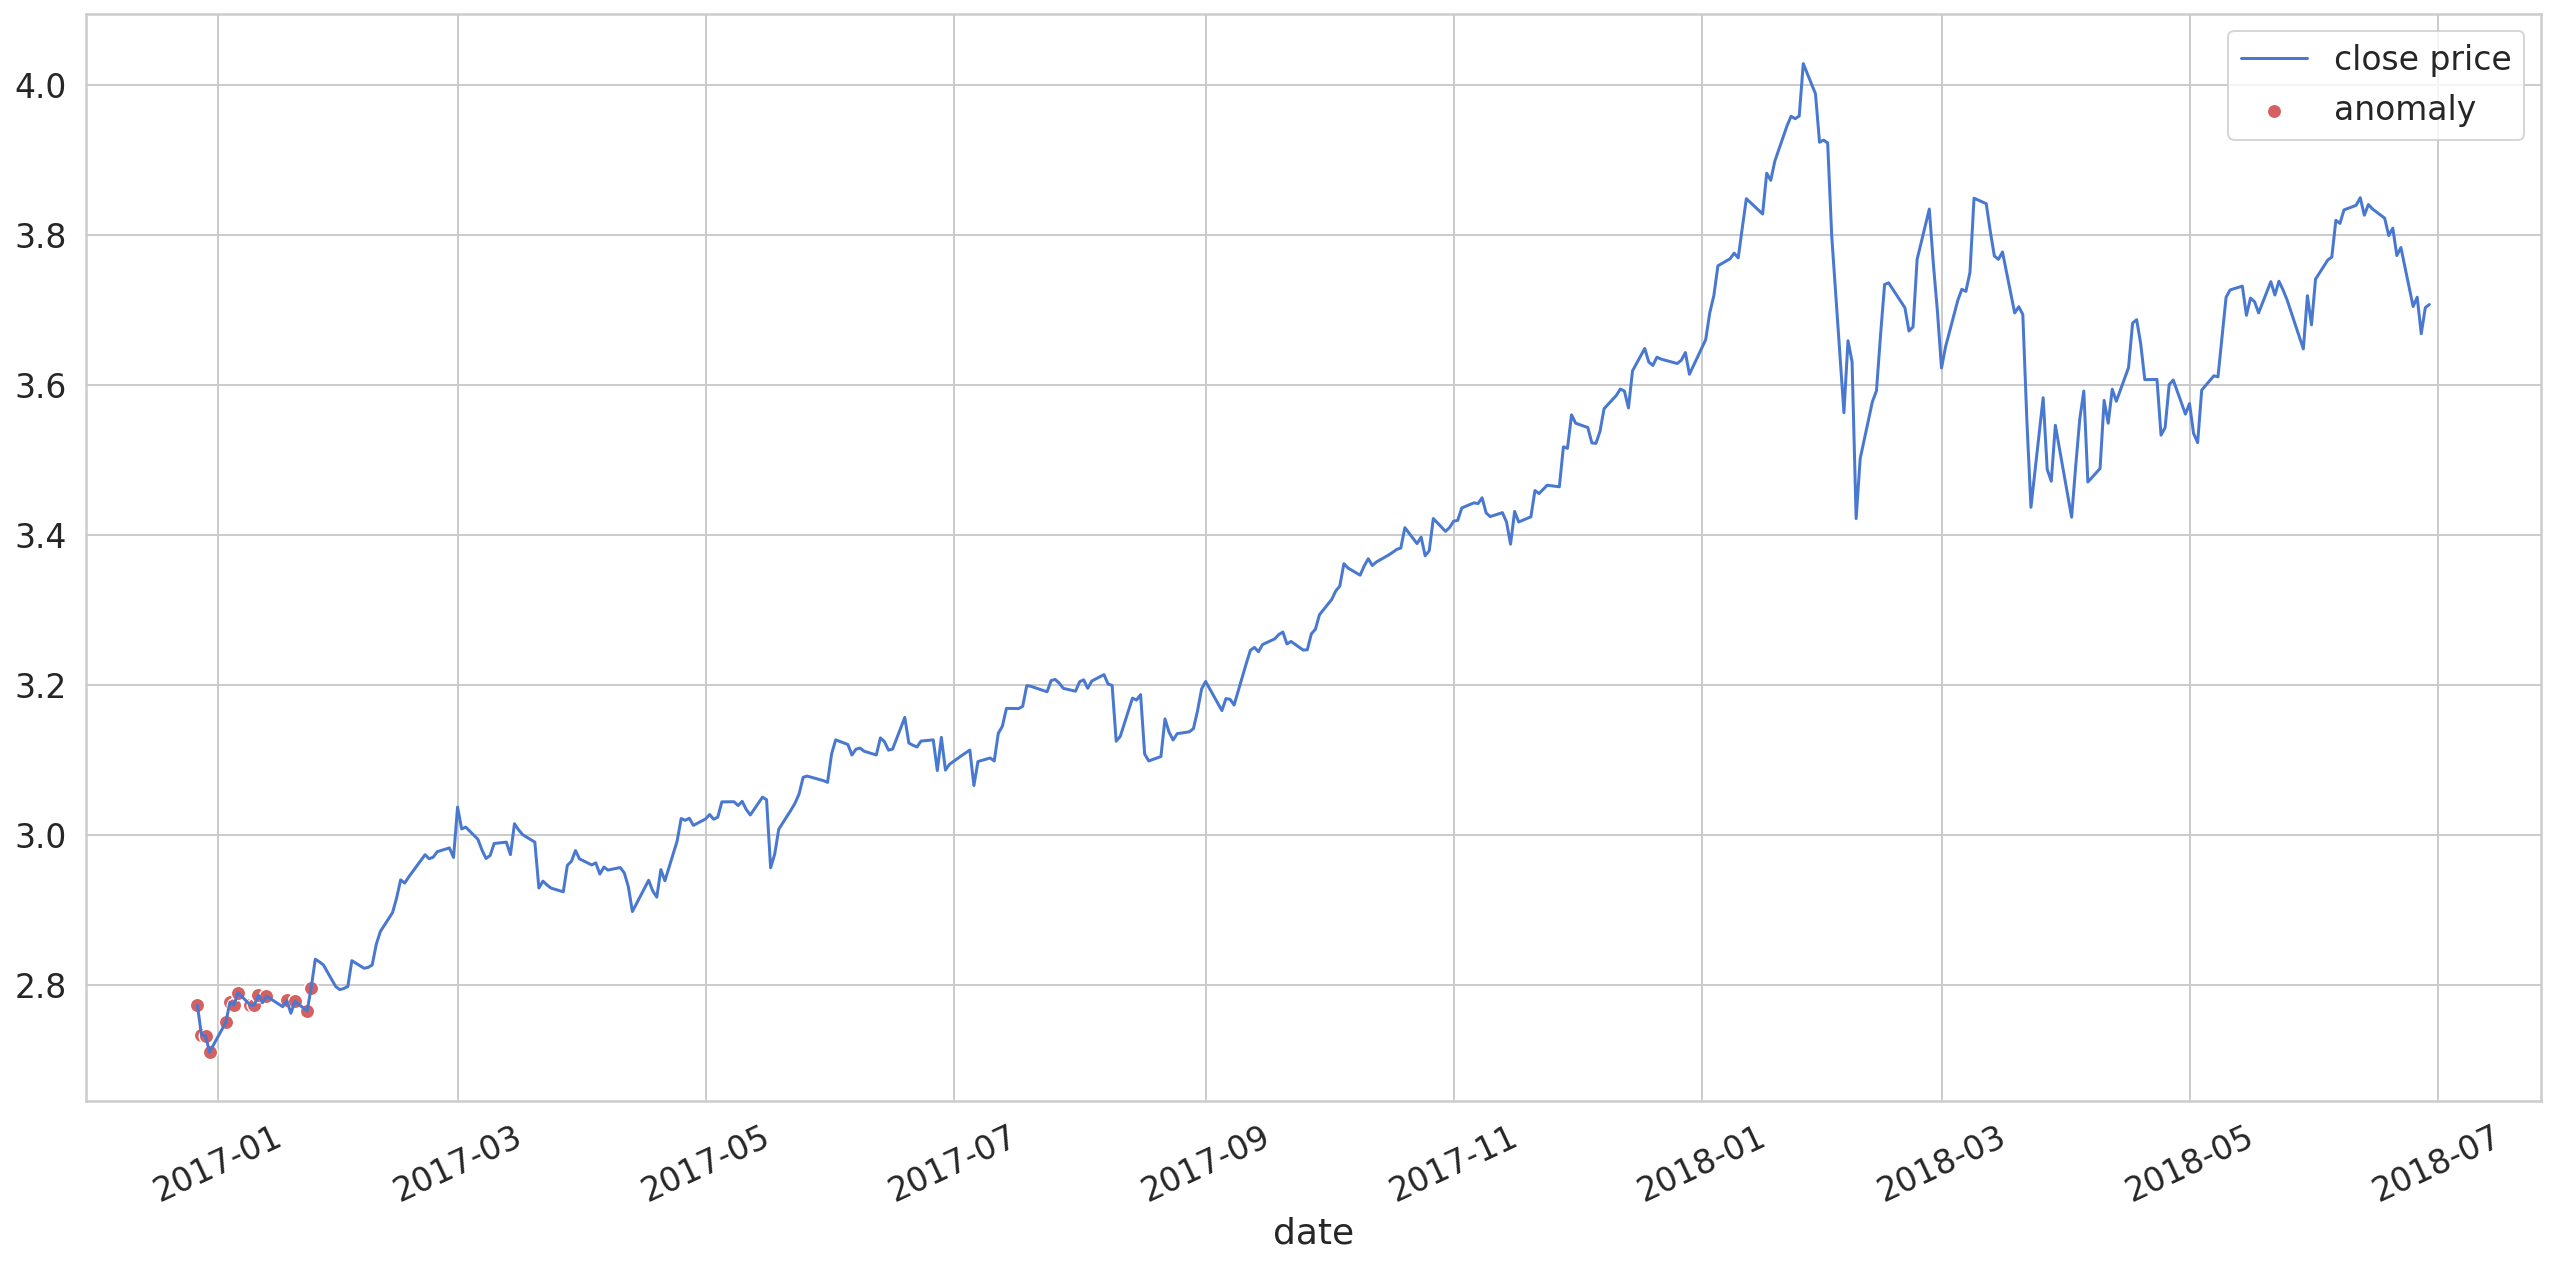

In [102]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();
